In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings
warnings.filterwarnings('ignore') 
import os, random, cv2, h5py
from glob import glob
from sklearn.preprocessing import OneHotEncoder
from itertools import chain
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc, jaccard_score

from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

from keras.layers import Input, Dropout, Flatten, Dense, AveragePooling2D, Conv2D, GlobalAveragePooling2D
from keras.optimizers import Adam, SGD
import np_utils
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, CSVLogger

Using TensorFlow backend.


In [2]:
import segmentation_models as sm
from segmentation_models import Unet
#from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss

#from segmentation_models.losses import DiceLoss
from segmentation_models.metrics import iou_score

Segmentation Models: using `keras` framework.


In [3]:
from albumentations import (
    Compose,
    HorizontalFlip,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    OneOf,
    CLAHE,
    RandomBrightnessContrast,    
    RandomGamma    
)

In [4]:
weights = [0.4, 0.6, 0.5, 1]

In [5]:
IOU = sm.metrics.IOUScore() #iou is also known as the jaccard score
Fscore = sm.metrics.FScore() #also known as dice coeff

loss = sm.losses.DiceLoss(class_weights = weights)
#loss = sm.losses.DiceLoss()
learning_rate = 0.001
lr='1e-3'
#loss = sm.losses.CategoricalCELoss(class_weights = weights)
loss_name = 'DiceLoss'

metrics = [IOU, Fscore]

In [6]:
opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False)

In [7]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [8]:
class_dict = {0:'BG', 1:'H',2:'L',3:'C'}

In [9]:
ytrain_dir = 'Masks_cat_4/Train'
xtrain_dir = 'Images/Segmenting/Train'

ytest_dir = 'Masks_cat_4/Test'
xtest_dir = 'Images/Segmenting/Test'

yval_dir = 'Masks_cat_4/Val'
xval_dir = 'Images/Segmenting/Val'

In [10]:
image_size = 256
batch_size = 8
epochs = 100
backbone = 'vgg16'

In [11]:
#save_path = f'Unet_b{batch_size}_e{epochs}_{backbone}_{lr}_aug_tl_weights_uncropped'

In [11]:
save_path = 'Unet_b8_e200_vgg16_1e-4_aug_tl_noweights_uncropped'

In [12]:
#img_folder = xtrain_dir
#n=os.listdir(img_folder)

In [13]:
#train_img = cv2.imread(os.path.join(img_folder,n[2]))/255.

In [14]:
#centre_img = train_img - cv2.meanStdDev(train_img)[0][0][0]

In [15]:
#std_img = centre_img/cv2.meanStdDev(train_img)[1][0][0]

In [16]:
aug = Compose([OneOf([
        ElasticTransform(p=1, alpha=200, sigma=200 * 0.05, alpha_affine=200 * 0.03),
        GridDistortion(p=1, border_mode=0, value=5)], p=0.8),
    CLAHE(p=0.8),
    HorizontalFlip(p=0.5),
    RandomBrightnessContrast(p=0.8),    
    RandomGamma(p=0.8)])

In [17]:
# own datagenerator

def data_gen(img_folder, mask_folder, batch_size=8, image_size=256, classes=4):
    c=0
    n=os.listdir(img_folder)
    random.shuffle(n)
    
    while (True):
        img = np.zeros((batch_size, image_size, image_size, 1)).astype('float')
        mask = np.zeros((batch_size, image_size, image_size, classes)).astype('float')
        
        for i in range(c, c+batch_size):
            
            train_img = cv2.imread(os.path.join(img_folder,n[i]), cv2.IMREAD_GRAYSCALE)
            train_mask = cv2.imread(os.path.join(mask_folder,n[i]), cv2.IMREAD_GRAYSCALE)
            
            augmented = aug(image=train_img, mask=train_mask)
            train_img = augmented['image']
            train_mask = augmented['mask']
            
            train_img = cv2.resize(train_img, (image_size, image_size))/255.
            train_img = train_img.reshape([image_size, image_size,1])
            
            img[i-c] = train_img #add to array img[0] img [1] etc
            
            
            train_mask = cv2.resize(train_mask, (image_size, image_size))
            train_mask = train_mask.ravel()
            train_mask = to_categorical(train_mask, num_classes=classes)
            train_mask = train_mask.reshape([image_size, image_size, classes])
            
            mask[i-c] = train_mask
            
        c+=batch_size
        if (c+batch_size>=len(os.listdir(img_folder))):
            c=0
            random.shuffle(n)
        
        yield img, mask

In [18]:
def test_gen(img_folder, mask_folder, batch_size=51, image_size=256, classes=4):
    c=0
    n=os.listdir(img_folder)
    n.sort() #always evaluate in the same order 
    #remove shuffling
    while (True):
        img = np.zeros((batch_size, image_size, image_size, 1)).astype('float')
        mask = np.zeros((batch_size, image_size, image_size, classes)).astype('float')
        
        for i in range(c, c+batch_size):
            
            train_img = cv2.imread(os.path.join(img_folder,n[i]), cv2.IMREAD_GRAYSCALE)/255.
            train_img = cv2.resize(train_img, (image_size, image_size))
            train_img = train_img.reshape([image_size, image_size,1])
            
            img[i-c] = train_img #add to array img[0] img [1] etc
            
            train_mask = cv2.imread(os.path.join(mask_folder,n[i]), cv2.IMREAD_GRAYSCALE)
            train_mask = cv2.resize(train_mask, (image_size, image_size))
            train_mask = train_mask.ravel()
            train_mask = to_categorical(train_mask, num_classes=classes)
            train_mask = train_mask.reshape([image_size, image_size, classes])
            
            mask[i-c] = train_mask
            
        c+=batch_size
        if (c+batch_size>=len(os.listdir(img_folder))):
            c=0
        
        yield img, mask

In [19]:
train_gen = data_gen(xtrain_dir, ytrain_dir,image_size=image_size, batch_size=batch_size)
val_gen = data_gen(xval_dir, yval_dir, image_size=image_size,batch_size=batch_size)
val_pred_generator =  test_gen(xval_dir, yval_dir, image_size=image_size, batch_size=51)
test_generator = test_gen(xtest_dir, ytest_dir, image_size=image_size, batch_size=51)

In [20]:
no_training_images = len(os.listdir(xtrain_dir))
no_val_images = len(os.listdir(xval_dir))


weights_path = filepath=(f'Weights/{save_path}.h5')

checkpoint = ModelCheckpoint(weights_path, monitor='val_loss', verbose=1, save_weights_only = True, save_best_only=True, mode='min')
csv_logger = CSVLogger(f'TrainingLog/{save_path}.out', append=True, separator=';')

earlystopping = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5)

callbacks_list = [checkpoint, csv_logger, earlystopping]


In [21]:
base_model = Unet(backbone_name='vgg16', encoder_weights='imagenet', classes=4, activation = 'softmax', encoder_freeze = True)

inp = Input(shape=(image_size, image_size, 1)) # need new input layer for 1-channel medical data

l1 = Conv2D(3, (1, 1))(inp) # map single channel to RGB channels
out = base_model(l1)

model = Model(inp, out, name=base_model.name)

In [22]:
model.load_weights(f'Weights/Unet_b8_e200_vgg16_1e-4_aug_tl_noweights_uncropped.h5')

In [23]:
model.compile(opt, loss=loss, metrics=metrics)

In [20]:
#model.load_weights(f'Weights/Unet_s{image_size}_b{batch_size}_e{epochs}_{backbone}_{loss_name}.best.hdf5')

In [21]:
results = model.fit_generator(train_gen, epochs=epochs, 
                          steps_per_epoch = (no_training_images*3//batch_size),
                          validation_data=val_gen,
                          validation_steps=(no_val_images//batch_size), 
                             verbose=1, 
                             callbacks = callbacks_list)


Epoch 1/100
88/88 [==============================] - 116s 1s/step - loss: 0.6056 - iou_score: 0.5622 - f1-score: 0.6814 - val_loss: 0.6523 - val_iou_score: 0.4902 - val_f1-score: 0.6348

Epoch 00001: val_loss improved from inf to 0.65234, saving model to Weights/Unet_b8_e100_vgg16_1e-3_aug_tl_weights_uncropped.h5
Epoch 2/100
88/88 [==============================] - 126s 1s/step - loss: 0.4745 - iou_score: 0.7722 - f1-score: 0.8657 - val_loss: 0.4888 - val_iou_score: 0.7600 - val_f1-score: 0.8573

Epoch 00002: val_loss improved from 0.65234 to 0.48881, saving model to Weights/Unet_b8_e100_vgg16_1e-3_aug_tl_weights_uncropped.h5
Epoch 3/100
88/88 [==============================] - 134s 2s/step - loss: 0.4591 - iou_score: 0.8009 - f1-score: 0.8852 - val_loss: 0.4812 - val_iou_score: 0.7504 - val_f1-score: 0.8504

Epoch 00003: val_loss improved from 0.48881 to 0.48120, saving model to Weights/Unet_b8_e100_vgg16_1e-3_aug_tl_weights_uncropped.h5
Epoch 4/100
88/88 [===========================

In [22]:
#model.evaluate_generator(test_generator, steps=1)

In [23]:
model.metrics_names

['loss', 'iou_score', 'f1-score']

In [24]:
#model.save(f'Models/Unet_s{image_size}_b{batch_size}_e{epochs}_{backbone}_{loss_name}.hdf5')

In [25]:
#for layer in model.layers:
#    layer.trainable = True

In [26]:
path = f'TrainingLog/{save_path}.out'
history = pd.read_csv(path, sep=';')

In [27]:
def plot_history(history, save=False, name=None):
    fig, (ax1, ax2) = plt.subplots(ncols=2)
    ax1.plot(history['iou_score'])
    ax1.plot(history['val_iou_score'])
    ax1.title.set_text('Model IoU')
    ax1.set_ylabel('IoU')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='lower right')
    
    # Plot training & validation loss values
    ax2.plot(history['loss'])
    ax2.plot(history['val_loss'])
    ax2.title.set_text('Model loss')
    ax2.set_ylabel('Dice Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper right')
    fig.tight_layout()
    fig.show()
    if save==False:
        return
    else:
        fig.savefig(f'Figures/{name}.png')
        
    return

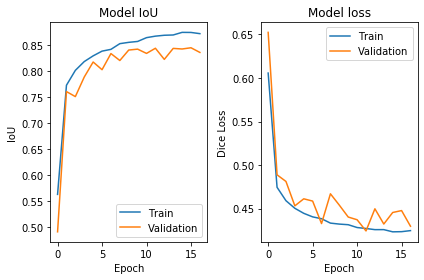

In [28]:
plot_history(history, save = True, name = save_path)

In [22]:
def get_class_jaccard(image_folder, mask_folder, generator):
    image_names = os.listdir(image_folder)
    image_names.sort()
    
    predictions = model.predict_generator(generator, steps=1)
    
    ytrue = np.zeros((51, image_size, image_size, 4)).astype('float')

    for i in range(51):
        target = cv2.imread(os.path.join(mask_folder, image_names[i]), cv2.IMREAD_GRAYSCALE)
        target = cv2.resize(target, (image_size, image_size))
        target = target.ravel()
        target = to_categorical(target, num_classes=4)
        target = target.reshape([image_size, image_size, 4])
        
        ytrue[i] = target
    
    ypred = np.argmax(predictions, axis=-1)
    ytrue = np.argmax(ytrue, axis=-1)
    
    scores = jaccard_score(ytrue.ravel(), ypred.ravel(), average=None)
    
    return print(f'BG: {scores[0]}, Heart: {scores[1]}, Lungs: {scores[2]}, Clavicles: {scores[3]}')

In [23]:
get_class_jaccard(xtest_dir, ytest_dir, test_generator)


BG: 0.9524311984718429, Heart: 0.7275492511187807, Lungs: 0.9057292099687795, Clavicles: 0.7818030728973284


In [31]:
#image_names = os.listdir(xtest_dir)
#image_names.sort()
#predictions = model.predict_generator(test_generator, steps=1)
#ypred = np.argmax(predictions, axis=-1)

In [32]:
get_class_jaccard(xval_dir, yval_dir, val_pred_generator)

BG: 0.9500066676344583, Heart: 0.7344750059205811, Lungs: 0.8946634549264763, Clavicles: 0.7816195795006571


In [26]:
#image_names = os.listdir(xval_dir)
#image_names.sort()
#predictions = model.predict_generator(val_pred_generator, steps=1)
#ypred = np.argmax(predictions, axis=-1)

In [34]:
image_names = os.listdir(xtest_dir)
image_names.sort()
predictions = model.predict_generator(test_generator, steps=1)
ypred = np.argmax(predictions, axis=-1)

In [38]:
def plot_pred(index, predictions = ypred, save=False):
    img = cv2.imread(os.path.join('Images/Segmenting/Val/',image_names[index]), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (image_size, image_size))   
    
    target = cv2.imread(os.path.join(yval_dir, image_names[index]), cv2.IMREAD_GRAYSCALE)
    target = cv2.resize(target, (image_size, image_size))
    
    scores = jaccard_score(target.ravel(), ypred[index].ravel(), average=None)
    
    fig = plt.figure(frameon=False)
    im1 = plt.imshow(img, cmap='gray')
    im2 = plt.imshow(ypred[index], cmap = 'plasma', alpha=0.4)
    plt.axis('off')
    plt.annotate(f'IoU Heart: {round(scores[1]*100,2)}, Lungs: {round(scores[2]*100,2)},\n Clavicles: {round(scores[3]*100,2)}',(image_size*0.1, image_size*0.95), color='white')
    
    if save == True:
        plt.savefig(f'Figures/{save_path}_{image_names[index]}.png')
    
    plt.show()

In [35]:
def plot_testpred(index, predictions = ypred, save=False):
    img = cv2.imread(os.path.join('Images/Segmenting/Test/',image_names[index]), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (image_size, image_size))   
    
    target = cv2.imread(os.path.join(ytest_dir, image_names[index]), cv2.IMREAD_GRAYSCALE)
    target = cv2.resize(target, (image_size, image_size))
    
    scores = jaccard_score(target.ravel(), ypred[index].ravel(), average=None)
    
    fig = plt.figure(frameon=False)
    im1 = plt.imshow(img, cmap='gray')
    im2 = plt.imshow(ypred[index], cmap = 'plasma', alpha=0.4)
    plt.axis('off')
    plt.annotate(f'IoU Heart: {round(scores[1]*100,2)}, Lungs: {round(scores[2]*100,2)},\n Clavicles: {round(scores[3]*100,2)}',(image_size*0.1, image_size*0.95), color='white')
    
    if save == True:
        plt.savefig(f'Figures/TestFigs/Unet_b8_e100_vgg16_1e-3_aug_tl_weights_uncropped_{image_names[index]}.png')
    
    plt.show()

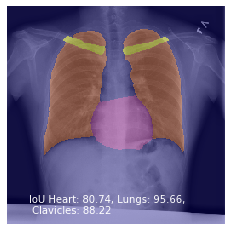

In [38]:
plot_testpred(26, ypred, save=True)

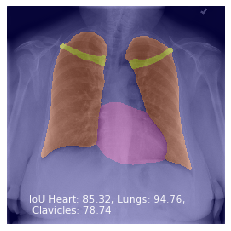

In [41]:
plot_pred(1, ypred, save=True)

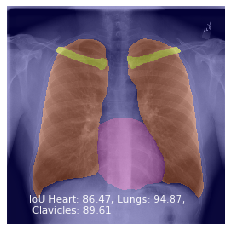

In [42]:
plot_pred(18, ypred, save=True)

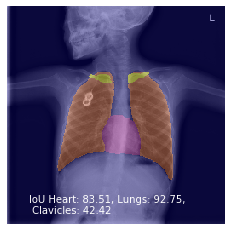

In [43]:
plot_pred(23, ypred, save=True)

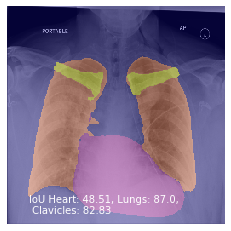

In [44]:
plot_pred(49, ypred, save=True)

In [24]:
folders = ['No Finding', 'Other', 'Pneumonia']
path = 'Images/Test'

In [25]:
def get_class_jaccard_disease(image_folder, mask_folder):
    image_names = os.listdir(image_folder)
    image_names.sort()
    
    gen = test_gen(image_folder, ytest_dir, image_size=image_size, batch_size=len(image_names))
    
    predictions = model.predict_generator(gen, steps=1)
    
    ytrue = np.zeros((len(image_names), image_size, image_size, 4)).astype('float')

    for i in range(len(image_names)):
        target = cv2.imread(os.path.join(mask_folder, image_names[i]), cv2.IMREAD_GRAYSCALE)
        target = cv2.resize(target, (image_size, image_size))
        target = target.ravel()
        target = to_categorical(target, num_classes=4)
        target = target.reshape([image_size, image_size, 4])
        
        ytrue[i] = target
    
    ypred = np.argmax(predictions, axis=-1)
    ytrue = np.argmax(ytrue, axis=-1)
    
    scores = jaccard_score(ytrue.ravel(), ypred.ravel(), average=None)
    
    return print(f'{os.path.basename(image_folder)}BG: {scores[0]}, Heart: {scores[1]}, Lungs: {scores[2]}, Clavicles: {scores[3]}')

In [30]:
target_folder = os.path.join(path, folders[2])

In [31]:
get_class_jaccard_disease(target_folder, ytest_dir)

PneumoniaBG: 0.9517981575348075, Heart: 0.7279582481693886, Lungs: 0.8962476439160677, Clavicles: 0.7319914674834546
